In [1]:
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pandas_profiling 


!pip install xgboost
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

### Loading Data 

In [2]:
df = pd.read_csv('Data Science excel.csv')
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [4]:

df.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,subscribed
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


### Clean Dataset

From the profile report, we know there are a few below problems need to be address

- Dataset has 12 (< 0.1%) duplicate rows 
- euribor3m is highly correlated with emp.var.rate (ρ = 0.97224) 
- nr.employed is highly correlated with euribor3m (ρ = 0.94515) 
- previous has 35563 (86.3%) zeros 


In [5]:
# Drop duplicates in the dataset
df.drop_duplicates()
df.shape

(41188, 21)

In [6]:
# drop columsn which are highly correlated as they don't add value to the performance of model prediction
col_to_drop = ['euribor3m']
df.drop(col_to_drop,axis=1,inplace=True)
df.shape

(41188, 20)

# 1: EDA & visulisation

,counts,percentage
no,36548,88.734583
yes,4640,11.265417


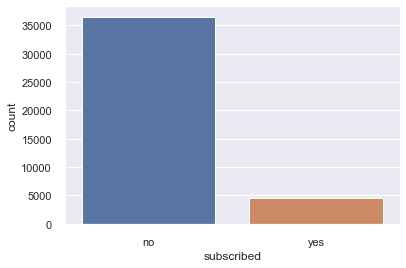

In [7]:
# successful subscribers vs failed subscribers
g = df['subscribed']
df_test = pd.concat([g.value_counts(),              
g.value_counts(normalize=True).mul(100)],axis=1,keys=('counts','percentage'))
display(df_test)

sns.set(style="darkgrid")
sns_plot=sns.countplot(x='subscribed', data=df)


# sns_plot.savefig("output.png")

### Observations: subscribed
- It is clear that the whole dataset is unbalanced with around 90% of subscribers and 10% non-subscribers. I might use resampling
  to generate more records to balance the dataset. 

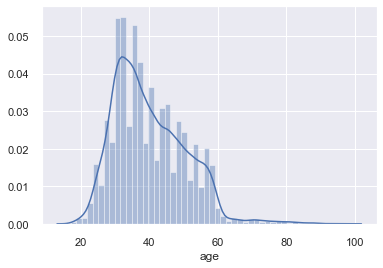

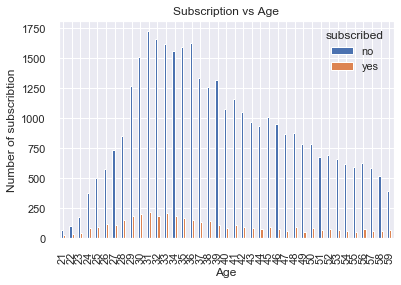

In [8]:
# Have a look at the age distribution
sns.distplot(df['age'])

# Most of the applications aged between 20-60. While we do further analysis, we can focus on the application in this group. 
df_small = df[(df['age']<60) & (df['age']>20)]
pd.crosstab(df_small.age,df_small.subscribed).plot(kind='bar')
plt.title('Subscription vs Age')
plt.xlabel('Age')
plt.ylabel('Number of subscribtion')
plt.savefig('subscribe_age')


### Observations: age  
 - There are a high concentration of clients' age is in between 30 to 40. It seems to suggest the campaign seem to focus on this group
    of clients than other ages. 
 - There are more subscribers at age 30-35 compared with other ages. So 'age' can be good indicator 
--------------------------------------------------------------------------------------------------------------------------------

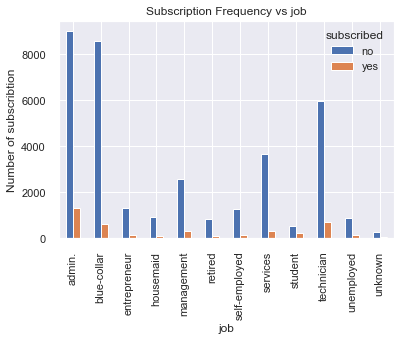

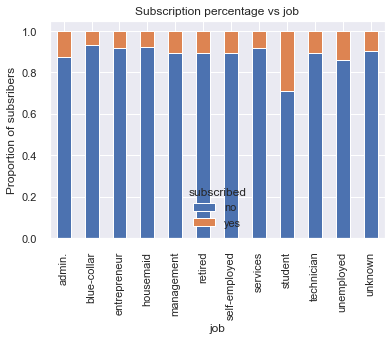

In [9]:
# Have a look at the job

pd.crosstab(df_small.job,df_small.subscribed).plot(kind='bar')
plt.title('Subscription Frequency vs job')
plt.xlabel('job')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs job')
plt.show()

table=pd.crosstab(df_small.job,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Subscription percentage vs job')
plt.xlabel('job')
plt.ylabel('Proportion of subsribers')
plt.savefig('sub_pct vs job')
plt.show()

### Observations: job
- From the number of subscription point of view, 'admin', 'technician' seems to have more subscribtion than other jobs. So 'job' can be a good indicator. 
- But in terms of subscription percentage, 'student' scores higher than any other jobs, followed by 'retired' and 'unemployed'. My suggestion would be perhaps target 
clients with 'student' profile. 
---------------------------------------------------------------------------------------------------------------------------------

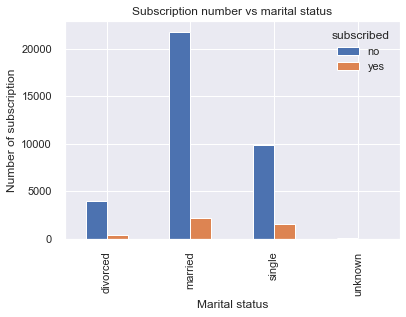

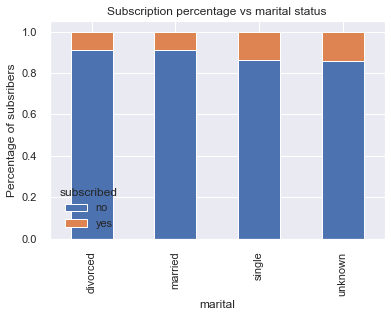

In [10]:
### Observation of marital stats vs subscribe

pd.crosstab(df_small.marital,df_small.subscribed).plot(kind='bar')
plt.title('Subscription number vs marital status')
plt.xlabel('Marital status')
plt.ylabel('Number of subscription')
plt.savefig('sub_num vs marital.png')
plt.show


table=pd.crosstab(df_small.marital,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title( 'Subscription percentage vs marital status')
plt.xlabel('marital')
plt.ylabel('Percentage of subsribers')
plt.savefig('sub_pct vs marital.png')
plt.show()

### Observations of marital status vs subscribe
- Most of the clients are married. But 'unknown' and 'single' has higher percentage of successful subscribe. I would suggest
  use some kind of technique to imputate/map out the marital status of unknown to get more accurate information.

In [11]:
# I noticed that there are a multiple education degree under basic, they can really be grouped into one called 'basic'
df_small.loc[df_small['education'].str.startswith('b'), 'education'] = 'basic'
df_small['education'].unique()

C:\Users\annab\Anaconda3\envs\ads08\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


array(['basic', 'high.school', 'professional.course', 'unknown',
       'university.degree', 'illiterate'], dtype=object)

In [12]:
print(df_small.shape)
df_small.head()

(39855, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,subscribed
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
3,40,admin.,married,basic,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,no


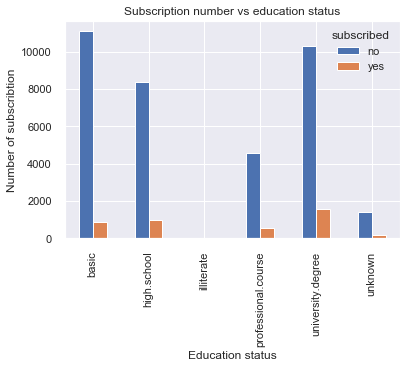

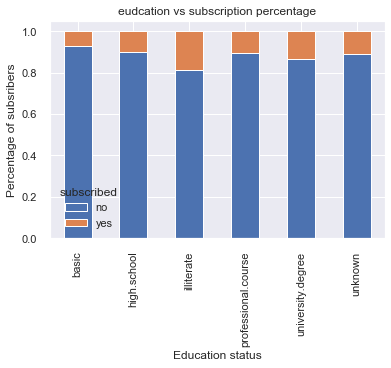

In [13]:
### Observation of education stats vs subscribe

pd.crosstab(df_small.education,df_small.subscribed).plot(kind='bar')
plt.title('Subscription number vs education status')
plt.xlabel('Education status')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs edu.png')
plt.show


table=pd.crosstab(df_small.education,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('eudcation vs subscription percentage')
plt.xlabel('Education status')
plt.ylabel('Percentage of subsribers')
plt.savefig('sub_pct vs edu.png')
plt.show()

### Observations: education 
- It is interesting to see that most of clients came from education background of 'basic' and 'university degree'. 
- Although there were not many clients from 'illiterate' background, but it tops up in terms of the percentage of 
  successful subscritions. Based on this I would suggest campaigners to focus a bit more on this group of people. 
- Education status is a good indicator for target variable. 

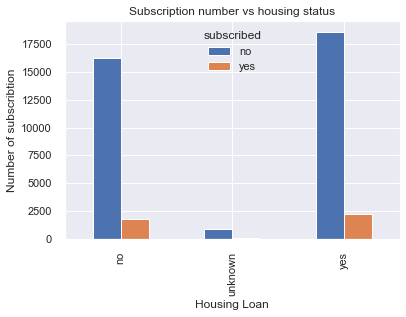

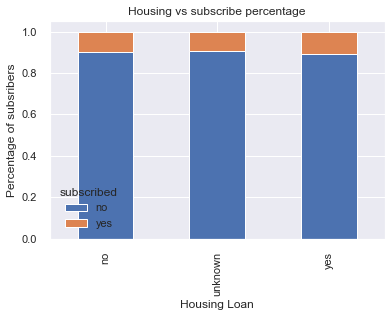

In [14]:
# Housing
pd.crosstab(df_small.housing,df_small.subscribed).plot(kind='bar')
plt.title('Subscription number vs housing status')
plt.xlabel('Housing Loan')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs housing')
plt.show


table=pd.crosstab(df_small.housing,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Housing vs subscribe percentage')
plt.xlabel('Housing Loan')
plt.ylabel('Percentage of subsribers')
plt.savefig('sub_pct vs housing')
plt.show()

### Observations: housing
- Not strong indications on the successfulness of subscribtion based on clients' housing status. 


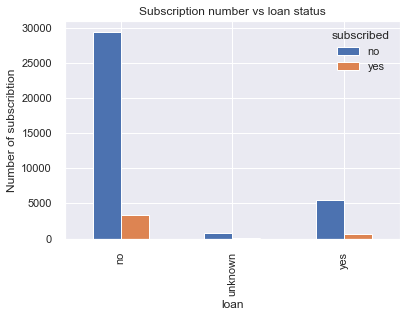

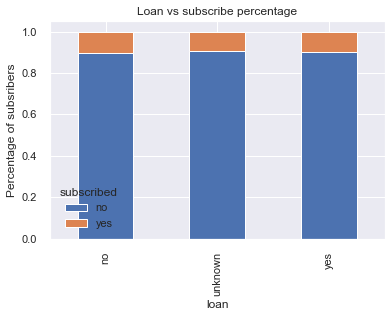

In [15]:
# Loan
pd.crosstab(df_small.loan,df_small.subscribed).plot(kind='bar')
plt.title('Subscription number vs loan status')
plt.xlabel('loan')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs loan')
plt.show


table=pd.crosstab(df_small.loan,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Loan vs subscribe percentage')
plt.xlabel('loan')
plt.ylabel('Percentage of subsribers')
plt.savefig('sub_pct vs loan')
plt.show()

### Observations on loan 
- Most of clients don't have loans, but the percentage of clients with no loans to subscribe the term deposit is just the same as others. So
  'loan' is not a good indicators for target variable.
    

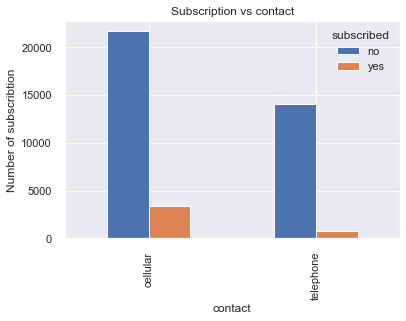

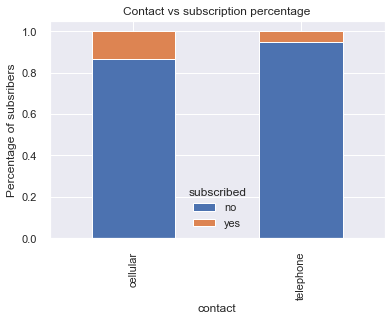

In [16]:
# We know from the report that there are more clients been contacted by 'cellular' than 'telephone'. But I want to see which
# marketing method is more effective in terms of getting subscription

pd.crosstab(df_small.contact,df_small.subscribed).plot(kind='bar')
plt.title('Subscription vs contact')
plt.xlabel('contact')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs contact')
plt.show

table=pd.crosstab(df_small.contact,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Contact vs subscription percentage')
plt.xlabel('contact')
plt.ylabel('Percentage of subsribers')
plt.savefig('sub_pct vs contact')
plt.show()

    

### Observations from 'contact'
- It looks like 'cellular' is used more than 'telephone' during the campaigns and it also generates higher percentage of subscribtion. 
so keep the good work.
- 'contact' can be a good indicator for the target variable.

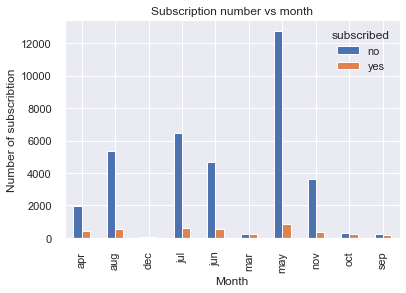

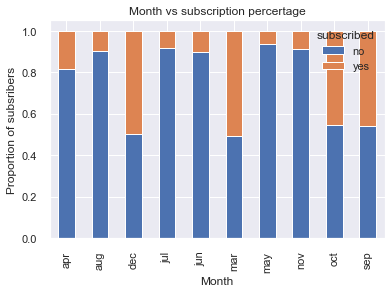

In [17]:
# Months
pd.crosstab(df_small.month,df_small.subscribed).plot(kind='bar')
plt.title('Subscription number vs month')
plt.xlabel('Month')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs month')
plt.show()


table=pd.crosstab(df_small.month,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Month vs subscription percertage')
plt.xlabel('Month')
plt.ylabel('Proportion of subsribers')
plt.savefig('sub_pct vs month')
plt.show()


### Observations: month
- There are no records for Jan and Feb. 
- More clients get to be contacted in May than any other month, but yet, it has the lowest percentage of subscriptions. While
  Dec, Mar, Oct and Sep have little number of contacts, but they both have the highest precentage of subscritions. My suggestion would be 
  put more campaigns/contact clients more during the Dec, Mar, Oct and Sep, instead of May. 

- 'month' is a good indicator of the target variable. 

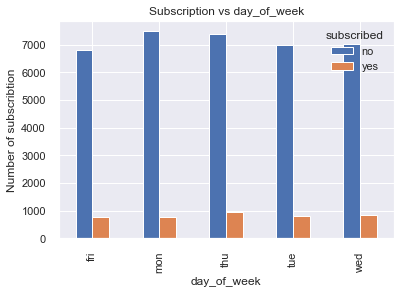

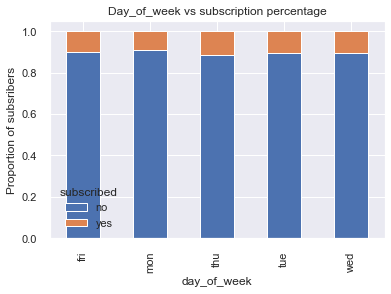

In [18]:
# Day of the week

pd.crosstab(df_small.day_of_week,df_small.subscribed).plot(kind='bar')
plt.title('Subscription vs day_of_week')
plt.xlabel('day_of_week')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs day_of_week')
plt.show()


table=pd.crosstab(df_small.day_of_week,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Day_of_week vs subscription percentage')
plt.xlabel('day_of_week')
plt.ylabel('Proportion of subsribers')
plt.savefig('sub_pct vs day_of_week')
plt.show()

### Observations: day_of_week
- There is no clear difference between different day in terms of the number and percentage of subscribtion, so I would say 'day_of_week' is not
  a good indicator for the target variable.

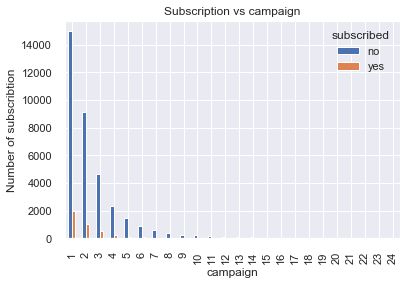

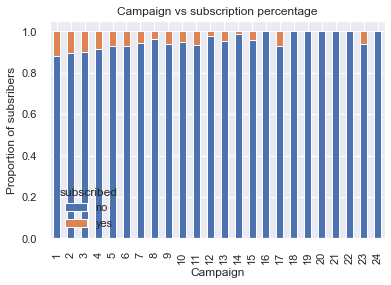

In [19]:
# Campaign
df_cam = df_small[df_small['campaign']<25]
pd.crosstab(df_cam.campaign,df_cam.subscribed).plot(kind='bar')
plt.title('Subscription vs campaign')
plt.xlabel('campaign')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs campaign')
plt.show()

table=pd.crosstab(df_cam.campaign,df_cam.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Campaign vs subscription percentage')
plt.xlabel('Campaign')
plt.ylabel('Proportion of subsribers')
plt.savefig('sub_pct vs campaign')
plt.show()

### Observations: campaign

- It is interesting to see that most of the clients are contacted less than 5 times. 
- There seems to be a trend that the less time clients get contacted, the more chance they will sign up the term deposit. But the trend
  seems to be gone after the clients been contacted more than 10 times.
- 'campaign' might be a good indicator of target variable.

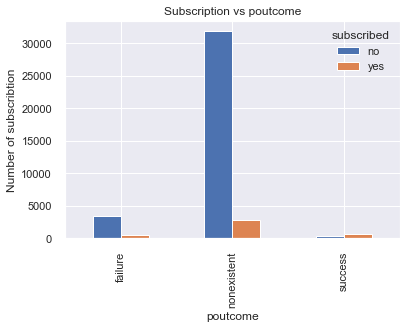

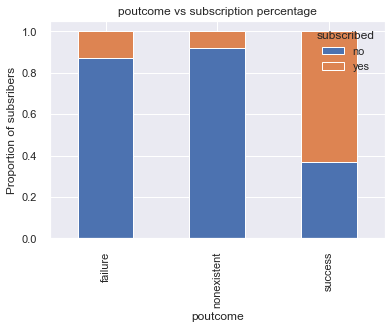

In [20]:
# poutcome

pd.crosstab(df_small.poutcome,df_small.subscribed).plot(kind='bar')
plt.title('Subscription vs poutcome')
plt.xlabel('poutcome')
plt.ylabel('Number of subscribtion')
plt.savefig('sub_num vs poutcome')
plt.show()


table=pd.crosstab(df_small.poutcome,df_small.subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('poutcome vs subscription percentage')
plt.xlabel('poutcome')
plt.ylabel('Proportion of subsribers')
plt.savefig('sub_pct vs poutcome')
plt.show()

### Observations: poutcome
- Most of the clients have not been contacted previously or does not have records about previous campaign. 
- The clients who were 'successful' on previous marketing campaign are more likely to buy this term deposite with 'failure'

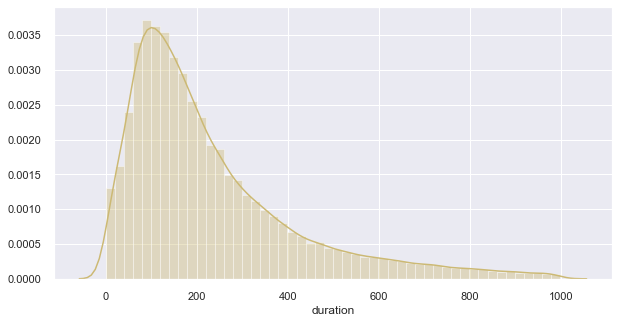

In [21]:
plt.figure(figsize=(10,5))
df_du=df_small[df_small['duration']<1000]
sns.distplot(df_du['duration'], color="y")



### Observations: Duration: 
From above distribution chart, we can see most of the duration is location between 60s-200s

In [22]:
df_small.groupby('subscribed').mean()


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed
subscribed,,,,,,,,,
no,39.410307,220.909467,2.641310,985.614117,0.126343,0.290219,93.612801,-40.659621,5178.335032
yes,37.878618,577.397470,2.081732,810.574070,0.445147,-1.109852,93.369111,-40.071199,5103.083362


### Observations on subscribed status on a few features. 
- The average age of clients with no subscribed is slightly older than clients with subscribed yes. 
- The average duration time spent on clients with yes are twice longer than clients with no. It makes sence as the call to sign up
 will be longer. 
- The avg number of contacts performed on clients with no is higher than clients with yes. 
- The pdays of clients with no is higher than clients with yes. I would suggest to contact the clients with no a bit more 
  frequent in the future to see if can win more subscrition. 
- The 'previous' of clients with yes are a lot higher than clients with no, it tells me that if contacting the clients more, if might
  win them to subscribe to the current products. 

## Preprocessing Data

In [23]:
# Preprocessing the data

y = df_small['subscribed']
X = df_small.drop('subscribed', axis=1)
print(X.shape)
display(X.head())
print("-"*40)
display(y[:10])

(39855, 19)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed
0,56,housemaid,married,basic,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0
3,40,admin.,married,basic,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0


----------------------------------------


0    no
1    no
2    no
3    no
4    no
5    no
6    no
7    no
8    no
9    no
Name: subscribed, dtype: object

,counts,percentage
no,36010,89.55261
yes,4201,10.44739


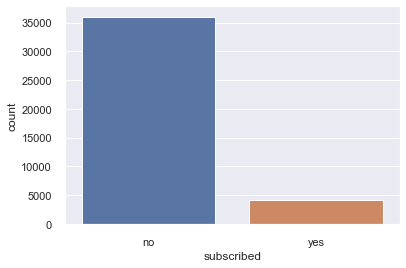

In [119]:
# We know the dataset is unbalanced. 
g = df_small['subscribed']
df_test = pd.concat([g.value_counts(),              
g.value_counts(normalize=True).mul(100)],axis=1,keys=('counts','percentage'))
display(df_test)

sns.set(style="darkgrid")
sns_plot=sns.countplot(x='subscribed', data=df_small)

In [1]:
# Next we SMOTE the whole dataset to balance the dataset first

from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0, 2], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

C:\Users\annab\Anaconda3\envs\ads08\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


ImportError: cannot import name 'SMOTENC'

In [24]:
# There are many categorical variables, so we will one hot encoder them.

col_cat = X.select_dtypes(include=['object']).columns
X_transformed = pd.get_dummies(data=X, columns=col_cat)
print(X_transformed.shape)
X_transformed.head()



(39855, 60)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,5191.0,1,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,5191.0,0,...,0,0,0,1,0,0,0,0,1,0


In [25]:
le = preprocessing.LabelEncoder()
y_transformed = le.fit_transform(y)
print(y_transformed)



[0 0 0 ... 0 0 1]


### Re-sampling the dataset to make it balanced


In [97]:
# I will use SMOTE method to generate synetheic records from minority dataset. 


# Make sure I only do this on training set, otherwise if the information will be leaked to test set
training_features, test_features, training_target, test_target = train_test_split(X_transformed, y_transformed, test_size=0.3, random_state=0)
columns = training_features.columns

X_train, X_val, y_train, y_val = train_test_split(training_features, training_target, test_size=.3, random_state=0)

from imblearn.over_sampling import SMOTE
method = SMOTE(kind='regular')
x_train_res,y_train_res = method.fit_sample(X_train, y_train)



In [98]:

from collections import Counter
print(sorted(Counter(y_train_res).items()))


[(0, 17594), (1, 17594)]


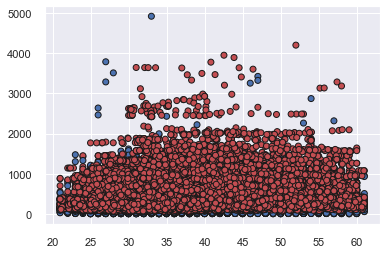

In [117]:
import matplotlib.pyplot as plt

def plot_classes(X,y):
    colours = ['b','r']
    point_colours = [colours[val] for val in y]
    X1 = X[:,0]
    X2 = X[:,1]
    plt.scatter(X1, X2, facecolor = point_colours, edgecolor = 'k')
    plt.show()
plot_classes(x_train_res, y_train_res)

### Observation
- We can see that the dataset now is balanced with equal amount number of target variable.

# Fit the models

In [99]:
#Logistic Regression
le = LogisticRegression()
le.fit(x_train_res,y_train_res)
y_pred_le = le.predict(X_val)
print('The accuracy score of Logistic Regression model is', le.score(X_val, y_val))

C:\Users\annab\Anaconda3\envs\ads08\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy score of Logistic Regression model is 0.8646536412078153


In [100]:
#Random Forest Classification
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)
y_pred_rf = clf_rf.predict(X_val)
print('The accuracy score of RandomForest classification model is', clf_rf.score(X_val, y_val))

The accuracy score of RandomForest classification model is 0.9132030787448194


In [101]:
from sklearn.metrics import *
recall_score(y_val, clf_rf.predict(X_val))

0.42399049881235157

In [102]:
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7603
           1       0.59      0.42      0.49       842

    accuracy                           0.91      8445
   macro avg       0.76      0.70      0.72      8445
weighted avg       0.90      0.91      0.91      8445



In [103]:
print ('Validation Results')
print (clf_rf.score(X_val, y_val))
print (recall_score(y_val, clf_rf.predict(X_val)))

print ('\nTest Results')
print (clf_rf.score(test_features, test_target))
print (recall_score(test_target, clf_rf.predict(test_features)))

Validation Results
0.9132030787448194
0.42399049881235157

Test Results
0.911472148541114
0.4460431654676259


### Observations
91% accuracy looks good, but I’m not just interested in accuracy. I also want to know how well I can specifically classify succssful subscription, 
since they’re more important which will be shown in recall. The number of recall measures the number of correct results, divided by the number of results 
that should have been returned. In this case is 45%. 


In [104]:
X_val[:5]

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
26980,31,1059,2,999,0,-0.1,93.200,-42.0,5195.8,0,...,0,0,0,0,1,0,0,0,1,0
35645,40,24,1,999,0,-1.8,92.893,-46.2,5099.1,1,...,0,0,0,1,0,0,0,0,1,0
28960,35,115,1,999,0,-1.8,93.075,-47.1,5099.1,1,...,0,0,1,0,0,0,0,0,1,0
29094,33,526,1,999,0,-1.8,93.075,-47.1,5099.1,1,...,0,0,1,0,0,0,0,0,1,0
22122,44,63,1,999,0,1.4,93.444,-36.1,5228.1,0,...,0,0,0,0,1,0,0,0,1,0


In [105]:
x_train_res[:5]

array([[ 3.4000e+01,  1.0500e+02,  1.0000e+00,  9.9900e+02,  0.0000e+00,
        -1.0000e-01,  9.3200e+01, -4.2000e+01,  5.1958e+03,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00],
       [ 2.4000e+01,  1.0600e+02,  1.0000e+00,  3.0000e+00,  1.0000e+00,
        -3.4000e

# Identify And Select Most Important Features

In [106]:
headers = ["name", "score"]

values = sorted(zip(X_train.columns, clf_rf.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))


name                                 score
duration                       0.217803
nr.employed                    0.0712744
emp.var.rate                   0.0666374
cons.conf.idx                  0.0394045
education_university.degree    0.0327528
cons.price.idx                 0.0298107
housing_yes                    0.0285943
housing_no                     0.0282683
marital_single                 0.0273479
contact_telephone              0.0271226
marital_married                0.0255158
age                            0.0221475
job_blue-collar                0.0210213
month_may                      0.0201816
job_admin.                     0.0191231
education_high.school          0.0191119
poutcome_nonexistent           0.0188532
contact_cellular               0.0184139
campaign                       0.0172446
default_no                     0.0143655
default_unknown                0.0135807
day_of_week_fri                0.0130372
previous                       0.0126716
pdays          

In [93]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(clf_rf, threshold=0.038)

# Train the selector
sfm.fit(x_train_res, y_train_res)


C:\Users\annab\Anaconda3\envs\ads08\lib\site-packages\sklearn\feature_selection\from_model.py:196: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=25, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=12, verbose=0,
     

In [107]:
# Print the names of the most important features
print('The most important 5 features are:')
for feature_list_index in sfm.get_support(indices=True):
    print(cols[feature_list_index])

The most important 5 features are:
duration
emp.var.rate
nr.employed


In [108]:
# create new dataset which has only the most important 5 features
X_important_train = sfm.transform(x_train_res)
X_important_test = sfm.transform(X_val)

In [109]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [110]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf_rf.predict(X_val)

from sklearn.metrics import accuracy_score
# View The Accuracy Of Our Full Feature (4 Features) Model
accuracy_score(y_val, y_pred)

0.9132030787448194

In [111]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (5 Features) Model
accuracy_score(y_val, y_important_pred)

0.8841918294849023

# Conclusion:
As can be seen by the accuracy scores, my original model which contained all full features is 91% accurate while the ‘limited’ model which contained only five features is 88% accurate. Thus, for a small cost in accuracy I reduced almost 75% of features in the model.